In [1]:
from brian2 import *
from brian2modelfitting import *
import numpy as np
import pandas as pd
import scipy.io
from scipy import signal

WARNING    /home/xeniasterl/anaconda3/lib/python3.7/site-packages/brian2modelfitting/utils.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
 [py.warnings]


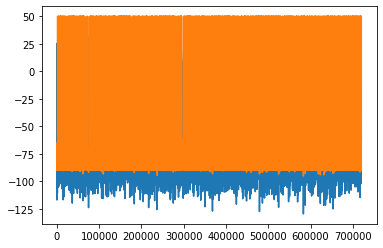

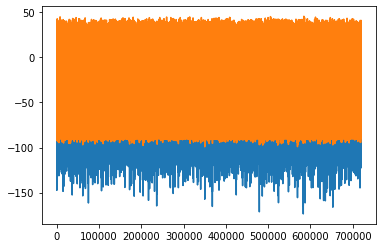

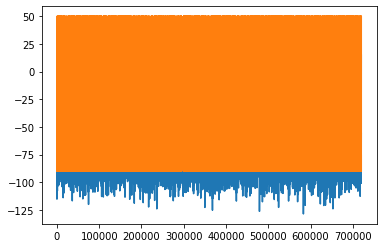

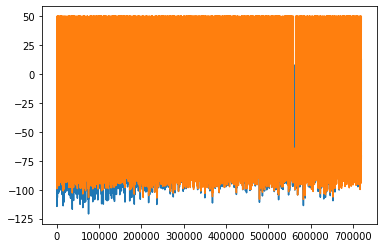

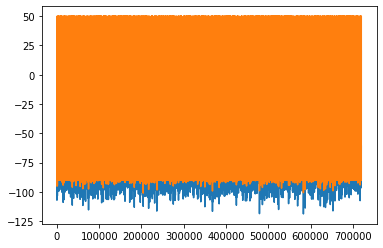

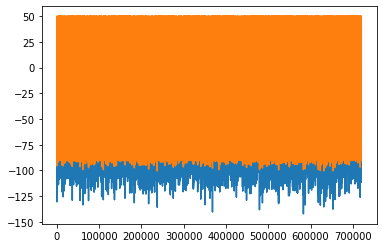

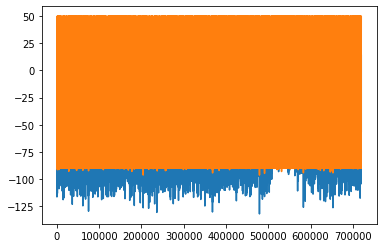

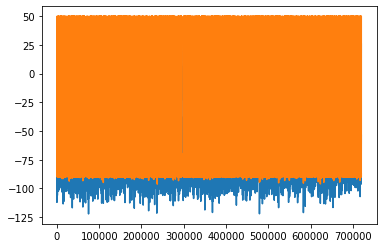

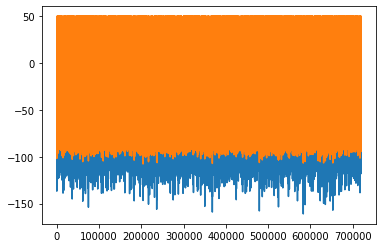

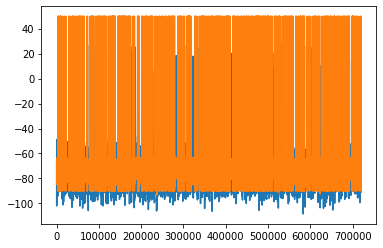

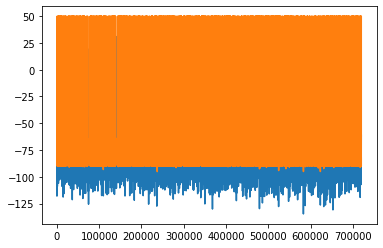

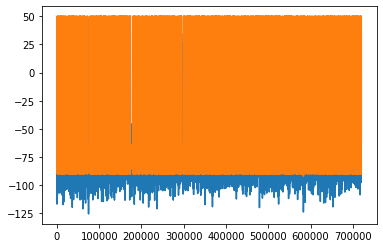

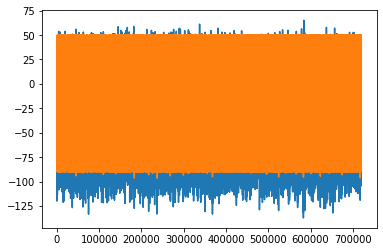

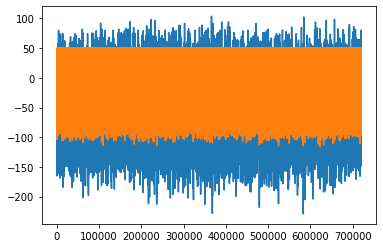

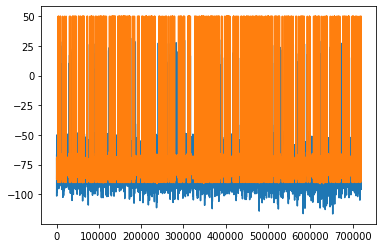

In [2]:
# Fit all parameters using TraceFitter

## Parameters
area = 20000*umetre**2
EL = -65*mV
EK = -90*mV
ENa = 50*mV
dt = 0.5*ms
param = math.log(10) #used in neuron equations

## Create lists for saving results
result_list = []
fits_trace_list = []
fits_spike_list = []
spiketimes_fitted_list = []

namelist = ['Dop_interneuron_1_aCSF', 'Dop_interneuron_2_aCSF', 'Dop_interneuron_3_aCSF', 'Dop_interneuron_4_aCSF', 
            'Dop_interneuron_5_aCSF', 'Dop_interneuron_6_aCSF', 'Dop_interneuron_7_aCSF', 'Dop_interneuron_8_aCSF', 
            'Dop_interneuron_9_aCSF', 'Dop_interneuron_10_aCSF', 'Dop_interneuron_11_aCSF', 'Dop_interneuron_12_aCSF', 
            'Dop_interneuron_13_aCSF', 'Dop_interneuron_14_aCSF', 'Dop_interneuron_15_aCSF']

spiketimes = scipy.io.loadmat('Dop_spiketimes_interneuron_aCSF')
spiketimes_array = spiketimes['spiketimes_cellarray']
rows = spiketimes_array.shape[0]
spiketimes_array = np.reshape(spiketimes_array, (rows,))

for name, spike_times in zip(namelist, spiketimes_array):
    
    data = scipy.io.loadmat(name)
    
    ## get output trace and resample
    out_trace = data['Data']['cell_response'][0][0].transpose()
    out_trace_resampled = signal.resample(out_trace, 720000, axis=1)
    out_trace_resampled = out_trace_resampled * pow(10, 3)
    out_trace = out_trace_resampled[0]
    
    ## get input current and resample
    in_current = data['Data']['input_current'][0][0].transpose()
    in_current_resampled = signal.resample(in_current, 720000, axis=1)
    in_current = in_current_resampled[0]
    
    ## Model Definition with all parameters to be fitted
    eqs = Equations(
    '''
    dv/dt = (-gNa*m**3*h*(v-ENa)-gK*n**4*(v-EK)-gL*(v-EL)-gK3*n3**4*(v-EK)+I)/Cm : volt

    # Activation gates Na channel
    m = 1/(1+exp(-(v-Vh)/k)) : 1
    Vh = 3.223725*k-62.615488*mV : volt

    # Inactivation gates Na channel
    dh/dt = 5*(alpha_h*(1-h)-beta_h*h) : 1
    alpha_h = 0.07*exp(-(v+58*mV)/(20*mV))/ms : Hz
    beta_h = 1./(exp(-0.1/mV*(v+28*mV))+1)/ms : Hz

    # Activation gates K channel
    dn/dt = 5*(alpha_n*(1-n)-beta_n*n) : 1
    alpha_n = 0.01/mV*10*mV/exprel(-(v+34*mV)/(10*mV))/ms : Hz
    beta_n = 0.125*exp(-(v+44*mV)/(80*mV))/ms : Hz

    # activation gates K3.1 channel
    dn3/dt = alphan3 * (1-n3) - betan3 * n3 : 1
    alphan3 =(1 / exp(((param*((-0.029 * v + (1.9*mV))/mV)))))/ms : Hz
    betan3 = (1 / exp(((param*((0.021 * v + (1.1*mV))/mV)))))/ms : Hz

    gK   : siemens (constant)
    gL   : siemens (constant)
    Cm   : farad (constant)
    gK3  : siemens(constant)
    gNa  : siemens (constant)
    k    : volt
    ''')

    ## Optimization and Metric Choice
    n_opt = NevergradOptimizer()
    metric = MSEMetric()

    ## Fitting
    fitter = TraceFitter(model=eqs, input_var='I', output_var='v',
                         input=[in_current]*amp, output=[out_trace]*mV, dt=dt,
                         n_samples=20,
                         param_init={'v': -65*mV},
                         method='exponential_euler')

    res, error_trace = fitter.fit(restart=True,
                            n_rounds=20,
                            optimizer=n_opt, metric=metric,
                            callback='progressbar',
                            gL = [1e-09 *siemens, 1e-07 *siemens],
                            gK = [6e-07*siemens, 6e-05*siemens],
                            Cm = [0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
                            gNa = [2e-06*siemens, 2e-04*siemens],
                            gK3 = [6e-04*siemens, 18e-03*siemens],
                            k = [0*mV, 20*mV])
    
    ## Visualization of the results
    fits_trace = fitter.generate_traces(params=None, param_init={'v': -65*mV})

#     plt.plot(out_trace.transpose())
#     plt.plot(fits_trace.transpose()/mV)

#     plt.show()

    # SpikeFitter

    ## Parameters volgens TraceFitter gefit op alles
    gL = res['gL']*siemens
    gK = res['gK']*siemens

    ## Model Definition with only gNa, gK3, Vh and k to be fitted
    eqs = Equations(
    '''
    dv/dt = (-gNa*m**3*h*(v-ENa)-gK*n**4*(v-EK)-gL*(v-EL)-gK3*n3**4*(v-EK)+I)/Cm : volt

    # Activation gates Na channel
    m = 1/(1+exp(-(v-Vh)/k)) : 1
    Vh = 3.223725*k-62.615488*mV : volt

    # Inactivation gates Na channel
    dh/dt = 5*(alpha_h*(1-h)-beta_h*h) : 1
    alpha_h = 0.07*exp(-(v+58*mV)/(20*mV))/ms : Hz
    beta_h = 1./(exp(-0.1/mV*(v+28*mV))+1)/ms : Hz

    # Activation gates K channel
    dn/dt = 5*(alpha_n*(1-n)-beta_n*n) : 1
    alpha_n = 0.01/mV*10*mV/exprel(-(v+34*mV)/(10*mV))/ms : Hz
    beta_n = 0.125*exp(-(v+44*mV)/(80*mV))/ms : Hz

    # activation gates K3.1 channel
    dn3/dt = alphan3 * (1-n3) - betan3 * n3 : 1
    alphan3 =(1 / exp(((param*((-0.029 * v + (1.9*mV))/mV)))))/ms : Hz
    betan3 = (1 / exp(((param*((0.021 * v + (1.1*mV))/mV)))))/ms : Hz

    gNa  : siemens (constant)
    gK3  : siemens
    k    : volt
    Cm   : farad
    ''')

    ## Set optimizer and metric
    n_opt = NevergradOptimizer()
    metric = GammaFactor(delta=2*ms, time=360000*ms)

    ## pass parameters to the NeuronGroup
    fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                         input=[in_current]*amp, output=spike_times,
                         n_samples=20,
                         threshold='m > 0.5',
                         param_init={'v': -70*mV},
                         reset=None,
                         refractory=2*ms)

    result_dict, error_spike = fitter.fit(n_rounds=20,
                                    optimizer=n_opt,
                                    metric=metric,
                                    callback='progressbar',
                                    gNa = [2e-06*siemens, 2e-04*siemens],
                                    gK3 = [6e-04*siemens, 18e-03*siemens],
                                    k = [0*mV, 20*mV],
                                    Cm = [0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area])

    ## Generate fitted spike times and trace
    spikes = fitter.generate_spikes(params=None)
    #print('spike times:', spikes)

    fits_spike = fitter.generate(params=None,
                           output_var='v')
    #print(fits_spike[0]/mV)

    ## Visualization of the results
    plt.plot(out_trace.transpose())
    plt.plot(fits_spike.transpose()/mV)

    plt.show()
    
    ## Save fitted parameters, traces and spike times
    gNa = result_dict['gNa']
    k = result_dict['k']
    gK3 = result_dict['gK3']
    Cm = result_dict['Cm']
    
    result_list.append([gL, gK, Cm, gNa, k, gK3, error_spike, error_trace])
    fits_trace_list.append(fits_trace)
    fits_spike_list.append(fits_spike)
    spiketimes_fitted_list.append(spikes)
    
    ## Delete variables before next round
    del gL, gK, Cm, gNa, k, gK3
    
result_array = np.asarray(result_list)
fits_trace_array = np.asarray(fits_trace_list)
fits_spike_array = np.asarray(fits_spike_list)
spiketimes_fitted_array = np.asarray(spiketimes_fitted_list)

np.save('Dop_results_interneuron_aCSF.npy', result_array)
np.save('Dop_fitted_trace_interneuron_aCSF.npy', fits_trace_array)
np.save('Dop_fitted_spike_interneuron_aCSF.npy', fits_spike_array)
np.save('Dop_fitted_spiketimes_interneuron_aCSF.npy', spiketimes_fitted_array)

# np.save('D1_results_interneuron_aCSF.npy', result_array)
# np.save('D1_fitted_trace_interneuron_aCSF.npy', fits_trace_array)
# np.save('D1_fitted_spike_interneuron_aCSF.npy', fits_spike_array)
# np.save('D1_fitted_spiketimes_interneuron_aCSF.npy', spiketimes_fitted_array)

# np.save('D2_results_interneuron_aCSF.npy', result_array)
# np.save('D2_fitted_trace_interneuron_aCSF.npy', fits_trace_array)
# np.save('D2_fitted_spike_interneuron_aCSF.npy', fits_spike_array)
# np.save('D2_fitted_spiketimes_interneuron_aCSF.npy', spiketimes_fitted_array)